# Santander Classification Problem

# Getting Started

> I am going to begin my first loading the training dataset and observing the first 5-10 rows of the datset. This will give me a clear picture as to what kind of data I am looking at.

In [1]:
import numpy as np
import pandas as pd

from IPython.display import display
%matplotlib inline

# Load the dataset
in_file = 'train.csv'
full_data = pd.read_csv(in_file)

print display(full_data.head())

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,39205.170000,0
1,3,2,34,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,49278.030000,0
2,4,2,23,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,67333.770000,0
3,8,2,37,0,195,195,0,0,0,0,...,0,0,0,0,0,0,0,0,64007.970000,0
4,10,2,39,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,117310.979016,0


None


In [14]:
outcomes = full_data['TARGET']
data = full_data.drop('TARGET', axis = 1)

#display(data.head())

3008
73012


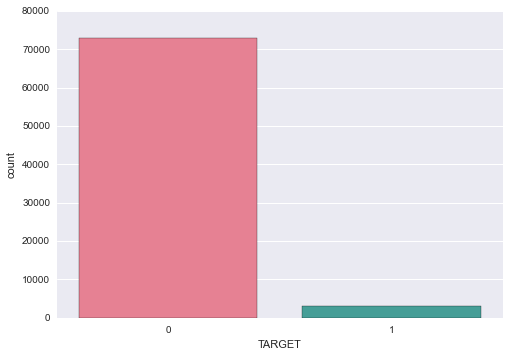

In [3]:
import seaborn as sns

sns.countplot(x='TARGET',data=full_data,palette="husl", order = range(2))

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import csv
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn import cross_validation
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import roc_auc_score
from sklearn.cross_validation import StratifiedKFold

def cleanUpScript(dataset):
    colsToRemove = []
    for col in dataset.columns:
        if dataset[col].std() == 0:
            colsToRemove.append(col)
    dataset.drop(colsToRemove, axis=1, inplace=True)
    return dataset

def removeAlmostAllZeros(dataset):
    num_non_zero=np.sum(dataset!=0,axis=0)
    num_non_zero_col = list(num_non_zero.index[num_non_zero<=19])
    print("Almost all zeros columes: ",num_non_zero_col)
    dataset.drop(num_non_zero_col, axis=1, inplace=True)
    return dataset
    
def removeDuplicateColumns(dataset):
    colsToRemove = []
    columns = dataset.columns
    for i in range(len(columns)-1):
        v = dataset[columns[i]].values
        for j in range(i+1,len(columns)):
            if np.array_equal(v,dataset[columns[j]].values):
                colsToRemove.append(columns[j])
    dataset.drop(colsToRemove, axis=1, inplace=True)
    return dataset

def selectFromModel():
    global X_new, modelTest
    clf = ExtraTreesClassifier()
    clf = clf.fit(data, outcomes)
    clf.feature_importances_
    modelTest = SelectFromModel(clf, prefit=True)
    X_new = modelTest.transform(data)
    
def testModel(model):
    model.fit(X_train, y_train)
    print model
    y_pred = model.predict(X_test)
    print metrics.accuracy_score(y_test, y_pred)
    print roc_auc_score(y_test, y_pred)

def actualTest(model):
    global X_train, modelTest, X_new
    in_file = 'test.csv'
    testing_data = pd.read_csv(in_file)
    testing_data = testing_data[[col for col in testing_data.columns if col in data.columns]]
    subset_testing_data =  testing_data #modelTest.transform(testing_data)
    return model.predict(subset_testing_data), testing_data

def outputSubmissionFile(y_out,testing_data):
    with open("submission.csv","w") as datafile:
        writer = csv.writer(datafile)
        output = []
        output.append(["ID","TARGET"])
        for i in range(len(y_out)):
            output.append([int(testing_data.iloc[i][0]), y_out[i]])
        writer.writerows(output)
        
def testGradientBoostingClassifier():
    return GradientBoostingClassifier(learning_rate = 1.0, n_estimators = 300, class_weight = {0:10, 1:1000})

def testRandomForestClassifier():
    clf = DecisionTreeClassifier(class_weight = {0:10, 1:1000})
    return clf

def generateSamples(outcomes):
    global X_new
    skf = StratifiedKFold(n_folds=2, y = outcomes)
    bestClf = None
    bestAccuracy = -1
    for train_index, test_index in skf:
        X_train, X_test = data.loc[train_index], data.loc[test_index]
        y_train, y_test = outcomes[train_index], outcomes[test_index]
        testing_class = [x for x in y_test if x == 1]
        print "unsatisfied class number:", str(len(testing_class))
        print "satisfied class number:", str(len(y_test) - len(testing_class))
        clf = RandomForestClassifier(class_weight = {1:1000, 0:0.001})
        model = clf.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print "accuracy:", metrics.accuracy_score(y_test, y_pred)
        print "roc score", roc_auc_score(y_test, y_pred)
        if metrics.accuracy_score(y_test, y_pred) > bestAccuracy:
            bestClf = model
    return bestClf
        

In [26]:
data = cleanUpScript(data)
data = removeDuplicateColumns(data)
data = removeAlmostAllZeros(data)

model = None
y_out = None
X_new = data
modelTest = None

#selectFromModel()
model = generateSamples(outcomes)
# X_train, X_test, y_train, y_test = cross_validation.train_test_split(
#     X_new, outcomes, stratify = outcomes)

# model = testGradientBoostingClassifier()

y_out, testing_data = actualTest(model)

outputSubmissionFile(y_out, testing_data)


('Almost all zeros columes: ', [])
unsatisfied class number: 1504
satisfied class number: 36506


ValueError: operands could not be broadcast together with shapes (38010,) (1500,) (38010,) 

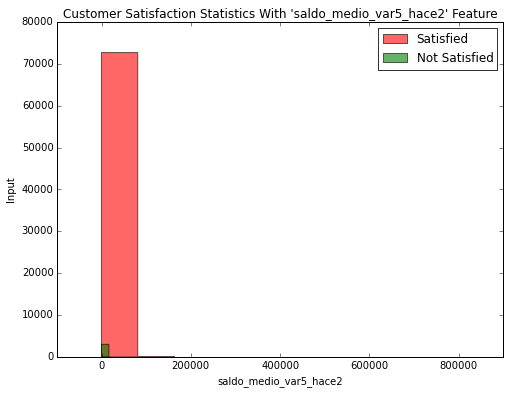

In [37]:
from santander_visualizations import satisfaction_stats

satisfaction_stats(data, outcomes, 'saldo_medio_var5_hace2')